### Data set formatting

In [1]:
import pandas as pd

#Converted to DataFrame
file = '../datasets/training_data.csv'
df = pd.read_csv(file) 

#Data set formatting
#Inputs:expression level of ERG8, ERG10, ERG12, ERG13, ERG19, ERG20, tHMG1, IDI1
#Output:Carotenoid Productivity

from pycaret.regression import *
exp1 = setup(
             df, 
             target = 'prod',  #Specify output values
             train_size = 0.8, #Specify the ratio of training data to test data
             data_split_shuffle = True,
             fold = 10, #Number of folds for cross-validation
             session_id = 1, 

             #variable transformation (Yeo-Johnson transformation)
             transformation_method = "yeo-johnson", transformation = True,
             transform_target_method = "yeo-johnson", transform_target = True,
)

#Train data of inputs
X_train_def =  get_config("X_train") 
#Train data of output
y_train_def = get_config("y_train")
#Test data of inputs
X_test_def =  get_config("X_test")
#Test data of output
y_test_def = get_config("y_test")
#All data of inputs
X = get_config("X")
#All data of outputs
y = get_config("y")

,Description,Value
0,session_id,1
1,Target,prod
2,Original Data,"(168, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(134, 8)"


### Building a single ML model

In [2]:
ada = create_model('ada')
ard = create_model('ard')
br = create_model("br")
dt = create_model("dt")
en = create_model("en")
et = create_model("et")
gbr = create_model("gbr")
huber = create_model("huber")
knn = create_model("knn")
kr = create_model("kr")
lar = create_model("lar")
lasso = create_model("lasso")
lightgbm = create_model("lightgbm")
llar = create_model("llar")
lr = create_model("lr")
mlp = create_model("mlp")
omp = create_model("omp")
par = create_model("par")
ransac = create_model("ransac")
rf = create_model("rf")
ridge = create_model("ridge")
svm = create_model("svm")
tr = create_model("tr")
xgboost = create_model("xgboost")

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.1469,6.2070,2.4914,-0.2280,0.4707,0.6541
1,1.5952,4.9202,2.2181,-0.3056,0.3563,0.2541
2,1.5999,3.2528,1.8036,0.2541,0.3499,0.4521
3,1.2328,2.5053,1.5828,0.1034,0.2860,0.2785
4,1.6682,4.2104,2.0519,0.1507,0.3427,0.4112
5,1.4166,3.5072,1.8727,-1.1680,0.3748,0.4584
6,1.8590,5.2436,2.2899,-0.2761,0.4069,0.4328
7,1.3736,2.8717,1.6946,0.4323,0.3180,0.3983
8,1.6487,3.7896,1.9467,-0.3369,0.3279,0.4235


### Building 3-layered stacking model

In [3]:
#Building a Meta-Model(Boosting model with kernel ridge)
boost = ensemble_model(kr, method = 'Boosting', n_estimators = 10)

#Specify base model combination
stack2=[br, dt, en, et, huber, lasso, lightgbm, llar, lr, mlp, omp, par, ransac, tr] 
stack1=[et, lightgbm, omp, xgboost]

#Buildeing stacking model
#meta:boost
#level1:stack1
#level2:stack2
stacker1 = stack_models(estimator_list = stack2, meta_model = boost, choose_better = False, optimize = 'R2')
stacker2 = stack_models(estimator_list = stack1, meta_model = stacker1, choose_better = False, optimize = 'R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8929,5.1284,2.2646,-0.0146,0.4246,0.5538
1,1.2866,3.2941,1.8150,0.1259,0.2692,0.2073
2,1.6656,3.6819,1.9188,0.1557,0.3431,0.3916
3,1.0142,1.9475,1.3955,0.3030,0.2384,0.2429
4,1.2232,2.4020,1.5498,0.5155,0.2846,0.3366
5,1.2263,2.6805,1.6372,-0.6570,0.3439,0.3940
6,1.5980,4.6868,2.1649,-0.1406,0.3598,0.3293
7,1.5451,4.8098,2.1931,0.0492,0.3863,0.4002
8,1.5907,3.7785,1.9438,-0.3331,0.3459,0.4237


### Visualizetion

In [7]:
exp2 = setup(
             df, 
             target = 'prod',  #Specify output values
             train_size = 0.8, #Specify the ratio of training data to test data
             data_split_shuffle = True,
             fold = 10, #Number of folds for cross-validation
             session_id = 1, 

             #variable transformation (Yeo-Johnson transformation)
             transformation_method = "yeo-johnson", transformation = False,
             transform_target_method = "yeo-johnson", transform_target = False,
)

#Train data of inputs
X_train =  get_config("X_train") 
#Train data of output
y_train = get_config("y_train")
#Test data of inputs
X_test =  get_config("X_test")
#Test data of output
y_test = get_config("y_test")

,Description,Value
0,session_id,1
1,Target,prod
2,Original Data,"(168, 9)"
3,Missing Values,False
4,Numeric Features,8
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(134, 8)"


Parity plot of train score

In [8]:
#From the output excel file, parity plots("Label" and "prod" columns) and approximate straight lines were drawn. 
#The calculated coefficient of determination was then used as the train score.

y_pred_train = predict_model(stacker2,data = X_train_def)
dfy_train = pd.DataFrame(y_train)
test = pd.concat([y_pred_train, dfy_train], axis=1)

test.to_csv("Parity_plot.train_score.csv")

Parity plot of test score

In [9]:
#From the output excel file, parity plots("Label" and "prod" columns) and approximate straight lines were drawn. 
#The calculated coefficient of determination was then used as the test score.

y_pred = predict_model(stacker2,data = X_test_def)
dfy_test = pd.DataFrame(y_test)
test = pd.concat([y_pred, dfy_test], axis=1)

test.to_csv("Parity_plot.test_score.csv")

SHAP (SHapley Additive exPlanations) score

Using 168 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/168 [00:00<?, ?it/s]

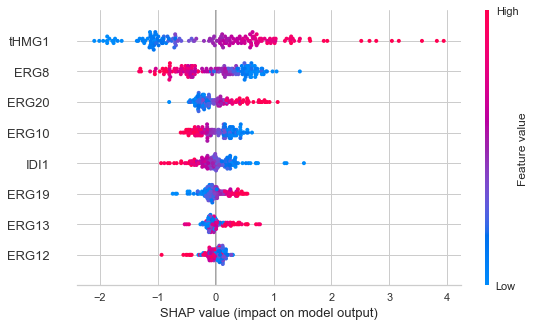

In [14]:
import shap
import matplotlib.pyplot as plt

model=stacker2

explainer = shap.KernelExplainer(model.predict, X)
shap_values = explainer.shap_values(X=X)
fig = shap.summary_plot(shap_values, X, plot_type='dot', show=False)
plt.savefig("sHAPy_1000dpi.png",dpi =1000)

### Prediction of optimal expression levels

In [15]:
from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import mean_squared_error, r2_score
import math,csv

#100,000 randomly generated gene expression ratios
df = pd.read_csv('predict_data.csv')

#Predicted carotenoid productivity("label" column of "predict_of_unknown.csv" table)
model=stacker2
y_pred = predict_model(model,data = df)
y_p = pd.DataFrame(y_pred)
y_p.to_csv("predict_of_unknown.csv")